# Best performing model tested on 2011-2018

In [2]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [7]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

ImportError: cannot import name 'read_train_data' from 'src.analysis' (/Users/tommylees/github/ml_drought/src/analysis/__init__.py)

# Read in the data

In [4]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

NameError: name 'read_train_data' is not defined

In [5]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [ ]:
ds.drop(['p84.162', 'ndvi', 'Eb', 'sp', 'tp']).to_netcdf('/Users/tommylees/Downloads/all_variables.nc')

In [9]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

In [8]:
bline_pred = read_pred_data('previous_month', data_dir)[-1].where(~mask)
lr_pred = read_pred_data('linear_regression', data_dir)[-1].where(~mask)
ln_pred = read_pred_data('linear_network', data_dir)[-1].where(~mask)
rnn_pred = read_pred_data('rnn', data_dir)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir)[-1].where(~mask)
ealstm_best_pred = read_pred_data('ealstm_omf_static_embedding', data_dir)[-1].where(~mask)

# ealstm_pred = read_pred_data('ealstm', data_dir)

## Explore how perform in each month

In [9]:
from src.analysis import annual_scores

In [10]:
# load the monthly scores dictionary
experiment = 'one_month_forecast'
monthly_scores = annual_scores(
    data_path=data_dir,
    models=['previous_month', 'rnn', 'linear_regression', 'linear_network', 'ealstm', 'ealstm_omf_static_embedding'],
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2011, 2019)],
    experiment=experiment,
    true_data_experiment=experiment,
    target_var='VCI',
    verbose=False,
    to_dataframe=True
)
monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
monthly_scores.head()

,ealstm,ealstm_omf_static_embedding,linear_network,linear_regression,month,previous_month,rnn,year,metric,time
0,13.402106,16.225477,22.490418,32.486778,1.0,9.795770,11.853916,2011.0,rmse,2011-01-01
1,7.842751,7.801312,9.924454,31.987063,2.0,8.340177,7.678180,2011.0,rmse,2011-02-01
2,8.938618,8.320612,10.103670,31.258896,3.0,9.269250,9.192322,2011.0,rmse,2011-03-01
3,10.506922,10.066308,12.409298,32.820860,4.0,11.361839,11.742179,2011.0,rmse,2011-04-01
4,11.106353,11.656133,16.207203,31.041736,5.0,13.613427,11.188204,2011.0,rmse,2011-05-01


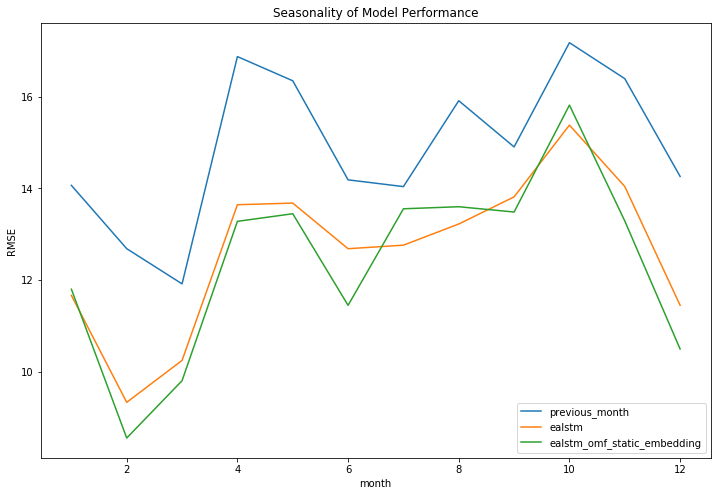

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'ealstm', 'ealstm_omf_static_embedding']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .groupby('month').mean().reset_index()
        .plot(x='month', y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Seasonality of Model Performance')
ax.set_ylabel('RMSE');

# (
#     monthly_scores
#     .where(monthly_scores.metric == 'rmse')
#     .groupby('month').mean().reset_index()
#     .plot(x='month', y=model, label=model, ax=ax)
# )

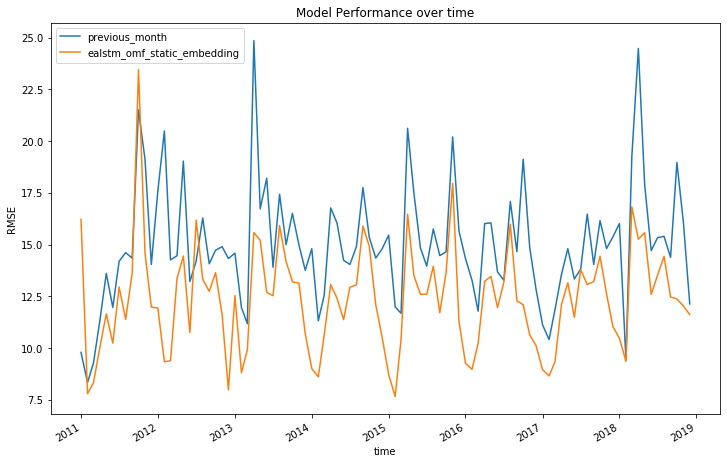

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
for model in ['previous_month', 'ealstm_omf_static_embedding']: # 
    (
        monthly_scores
        .where(monthly_scores.metric == 'rmse')
        .set_index('time')
        .plot(y=model, label=model, ax=ax)
    )
plt.legend()
ax.set_title('Model Performance over time')
ax.set_ylabel('RMSE');


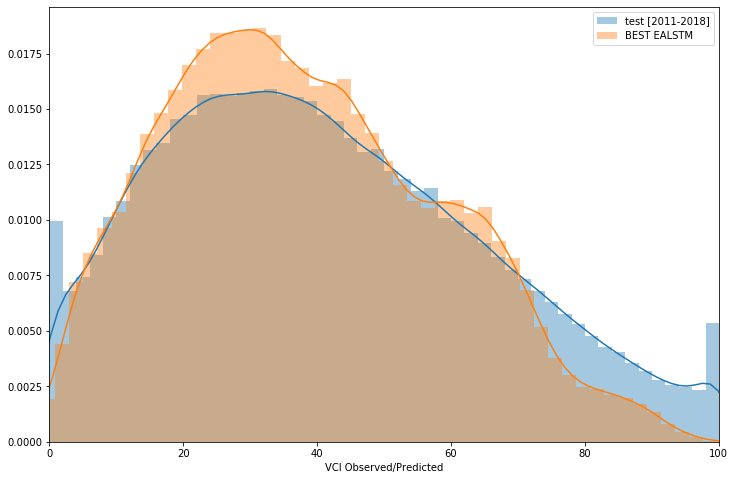

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(drop_nans_and_flatten(y_test.VCI), ax=ax, label='test [2011-2018]')
# sns.distplot(drop_nans_and_flatten(y_train.VCI), ax=ax, label='train [1982-2010]')
# sns.distplot(drop_nans_and_flatten(ealstm_pred), ax=ax, label='Previous EALSTM')
sns.distplot(drop_nans_and_flatten(ealstm_best_pred), ax=ax, label='BEST EALSTM')

ax.set_xlim([0, 100])
plt.legend()
ax.set_xlabel('VCI Observed/Predicted');

# Model Performance Comparisons

In [14]:
from src.analysis import spatial_rmse, spatial_r2
%autoreload 2

In [15]:
ealstm_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    ealstm_best_pred.transpose("time", "lat", "lon")
)

# --------
bline_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# --------
ealstm_base_rmse = spatial_rmse(
    y_test.VCI.transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
ealstm_mean = ealstm_rmse.mean().values
bline_mean = bline_rmse.mean().values
ealstm_base_mean = ealstm_base_rmse.mean().values

In [16]:
rmses = [bline_rmse, ealstm_rmse]
means = [bline_mean, ealstm_mean]
labels = ['Basline', 'EALSTM']
colors = sns.color_palette()[:len(means)]

assert (len(rmses) == len(means)) &  (len(labels) == len(colors))
assert (len(rmses) == len(labels))

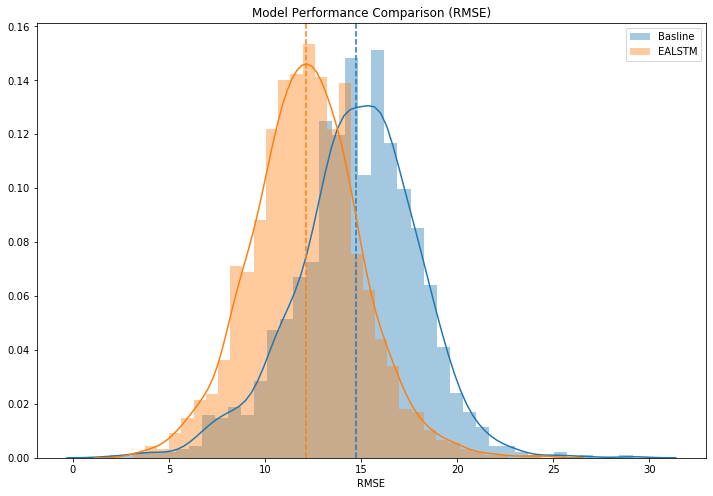

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(rmses)):
    rmse = rmses[i]
    mean = means[i]
    label = labels[i]
    color = colors[i]
    sns.distplot(
        drop_nans_and_flatten(rmse), ax=ax,
        label=label, color=color
    )
    ax.axvline(mean, ls='--', color=color) # , label=f'{label}_mean'

plt.legend()
ax.set_xlabel('RMSE');
ax.set_title('Model Performance Comparison (RMSE)');
# ax.set_ylabel('Density')

Baseline EALSTM RMSE:  12.48606477255771
Best performing EALSTM RMSE:  12.141921257161474


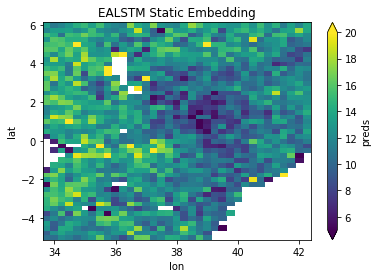

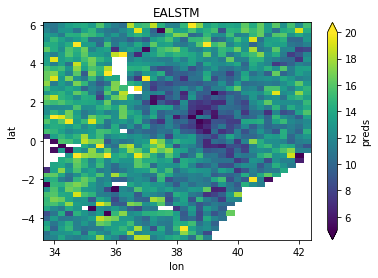

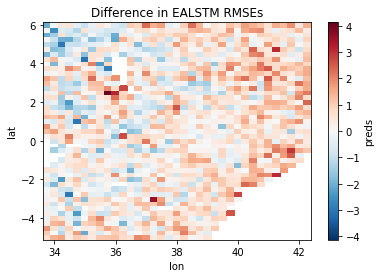

In [18]:
fig, ax = plt.subplots()
ealstm_rmse.plot(vmin=5, vmax=20, ax=ax)
ax.set_title('EALSTM Static Embedding')

fig, ax = plt.subplots()
ealstm_base_rmse.plot(vmin=5, vmax=20, ax=ax)
ax.set_title('EALSTM')

fig, ax = plt.subplots()
(ealstm_base_rmse - ealstm_rmse).plot(ax=ax)
ax.set_title('Difference in EALSTM RMSEs')


print("Baseline EALSTM RMSE: ", ealstm_base_rmse.mean().values)
print("Best performing EALSTM RMSE: ", ealstm_rmse.mean().values)

# Regional Analysis

In [19]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)

r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['ealstm', 'ealstm_ERA5_128', 'ealstm_omf_static_embedding', 'linear_network', 'linear_network_10stopping', 'linear_regression', 'previous_month', 'rnn', 'rnn_10stopping']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed


In [20]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

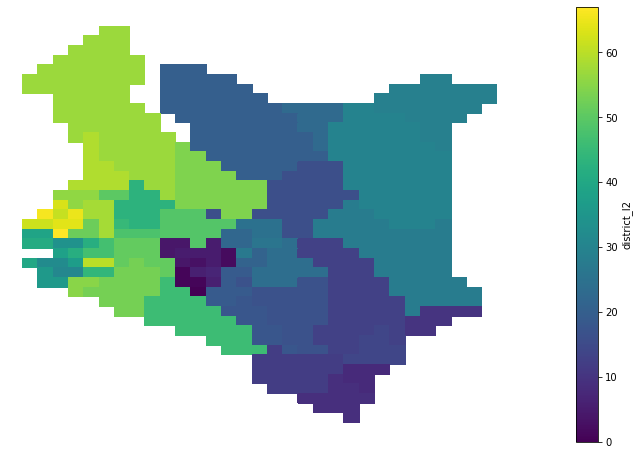

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
region_da.plot(ax=ax)
ax.set_axis_off()

# region_da.where(region_da == dict(zip(region_lookup.values(), region_lookup.keys()))['NAIROBI'])

In [22]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

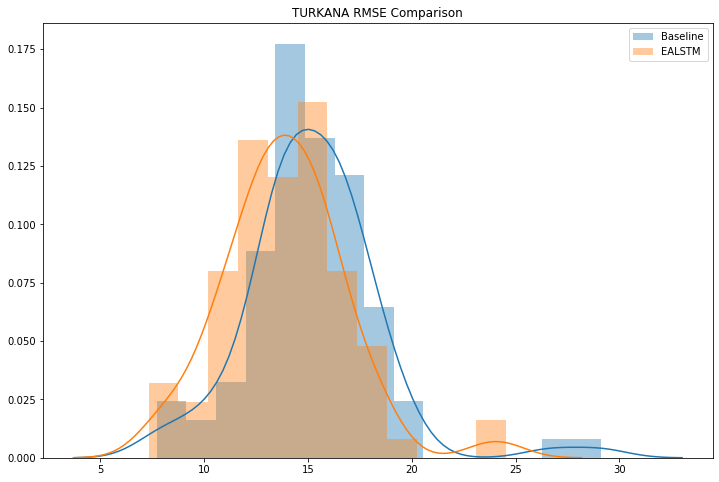

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
region = 'TURKANA'
msk = get_region_mask(region)
sns.distplot(drop_nans_and_flatten(bline_rmse.where(msk)), label='Baseline')
sns.distplot(drop_nans_and_flatten(ealstm_rmse.where(msk)), label='EALSTM')
# sns.distplot(drop_nans_and_flatten(ealstm_rmse.where(msk)), label='EALSTM Best')
ax.set_title(f'{region} RMSE Comparison')
plt.legend();

### Make region dataframe

In [24]:
from src.analysis import AdministrativeRegionAnalysis
# analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)

In [25]:
import pickle
warnings.filterwarnings('ignore')

if (data_dir / 'analysis/admin_region_analyzer_BEST.pkl').exists():
    analyzer = pickle.load(open(data_dir / 'analysis/admin_region_analyzer_BEST.pkl', 'rb'))
else:
    analyzer = AdministrativeRegionAnalysis(data_dir=data_dir)
    analyzer.analyze()
    
    with open(data_dir / 'analysis/admin_region_analyzer_BEST.pkl', 'wb') as f:
        pickle.dump(analyzer, f)

In [26]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [27]:
# join true/preds into a GeoDataFrame
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
# all_gdf['predicted_mean_value'] = all_gdf.predicted_mean_value * 10
# all_gdf['true_mean_value'] = all_gdf.true_mean_value * 10
all_gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,ealstm,2011-01-31,NAIROBI,34.205864,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
1,district_l2_kenya,rnn,2011-01-31,NAIROBI,57.911991,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
2,district_l2_kenya,ealstm_omf_static_embedding,2011-01-31,NAIROBI,60.318489,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
3,district_l2_kenya,rnn_10stopping,2011-01-31,NAIROBI,67.411308,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...
4,district_l2_kenya,previous_month,2011-01-31,NAIROBI,54.387498,56.869999,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...


In [28]:
np.unique(all_gdf.model)

array(['ealstm', 'ealstm_ERA5_128', 'ealstm_omf_static_embedding',
       'linear_network', 'linear_network_10stopping', 'linear_regression',
       'previous_month', 'rnn', 'rnn_10stopping'], dtype=object)

### Spatial Patterns

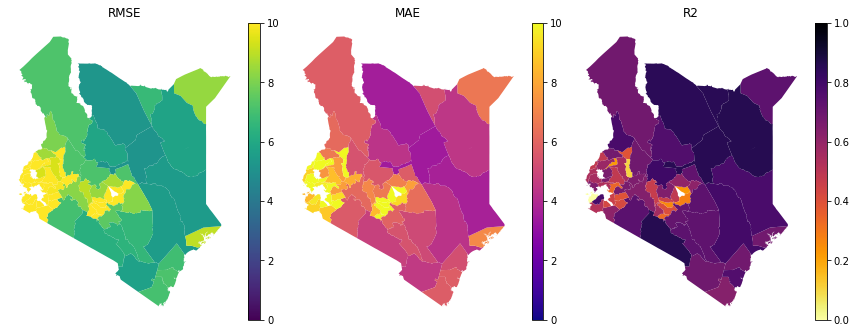

In [29]:
%autoreload 2
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'ealstm').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

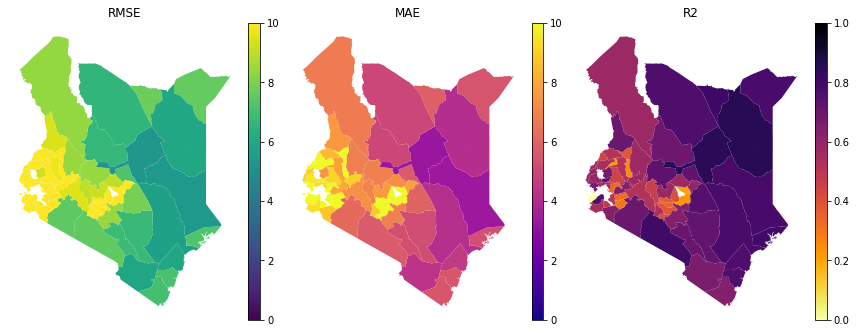

In [30]:
%autoreload 2
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'ealstm_omf_static_embedding').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

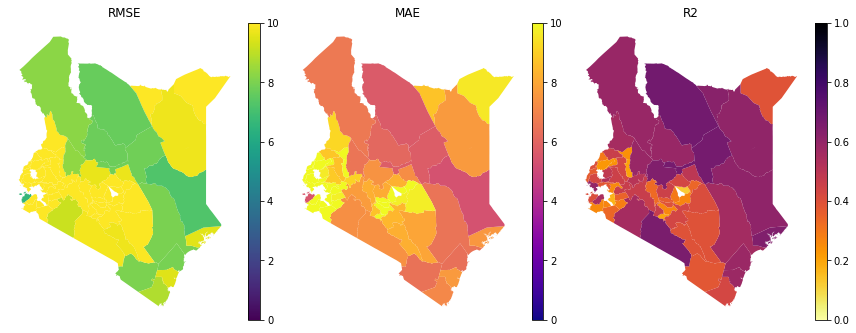

In [31]:
region_plotter.plot_all_regional_error_metrics(
    gdf.where(gdf.model == 'previous_month').dropna(),
    **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Normalise by variance
- explore the patterns independent of how variable the VCI values are over time
- Controlling for how much the VCI changes, how do our spatial patterns of variability look?

In [32]:
# gdf.head()
variances = all_gdf.groupby('region_name').true_mean_value.std()
variances.head()

region_name
BARINGO    12.947034
BOMET      18.968375
BONDO      23.772285
BUNGOMA    20.388922
BURET      14.889038
Name: true_mean_value, dtype: float64

In [33]:
# # 
# gdf = gdf.drop(columns=['norm_rmse', 'norm_r2', 'norm_mae'])
gdf_norm = gdf.copy()
gdf_norm = gdf.rename(columns={'rmse': 'rmse_', 'r2': 'r2_', 'mae': 'mae_'})
gdf_norm['rmse'] = (gdf_norm.rmse_ / variances.loc[gdf.region_name].values) * gdf_norm.rmse_.mean()
gdf_norm['r2'] = (gdf_norm.r2_ / variances.loc[gdf.region_name].values) * gdf_norm.rmse_.mean()
gdf_norm['mae'] = (gdf_norm.mae_ / variances.loc[gdf.region_name].values) * gdf_norm.rmse_.mean()
gdf_norm.head()

# variances.loc[gdf.region_name].values

,model,admin_level_name,region_name,rmse_,mae_,r2_,DISTNAME,geometry,rmse,r2,mae
0,ealstm,district_l2_kenya,NAIROBI,16.114892,12.969779,0.334930,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...,14.828072,0.308185,11.934106
1,ealstm_omf_static_embedding,district_l2_kenya,NAIROBI,15.206247,11.817655,0.407816,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...,13.991985,0.375251,10.873982
2,rnn,district_l2_kenya,NAIROBI,16.681192,13.233586,0.287366,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...,15.349152,0.264419,12.176847
3,previous_month,district_l2_kenya,NAIROBI,17.716596,13.530419,0.196154,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...,16.301876,0.180490,12.449977
4,linear_network_10stopping,district_l2_kenya,NAIROBI,35.182081,21.369534,-2.169972,NAIROBI,POLYGON ((36.90575473150634 -1.159051062893981...,32.372693,-1.996694,19.663117


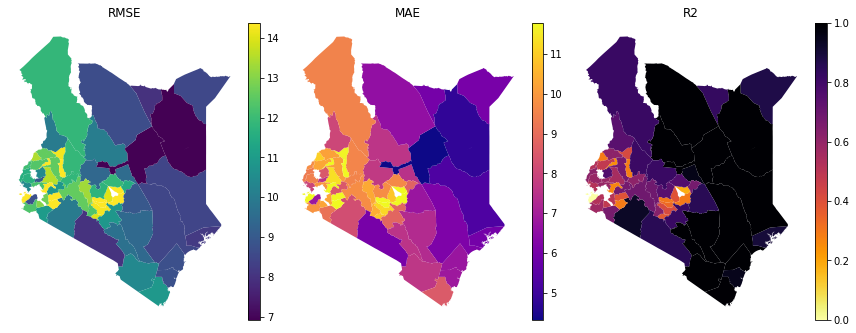

In [34]:
%autoreload 2
region_plotter.plot_all_regional_error_metrics(
    gdf_norm.where(gdf_norm.model == 'ealstm_omf_static_embedding').dropna(),
#     **dict(rmse_vmax=10, mae_vmax=10, mae_vmin=0, rmse_vmin=0)
);
# plt.gcf().suptitle('RNN Regional Errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Explore Time series

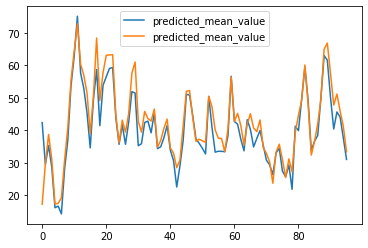

In [35]:
ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm_omf_static_embedding')].predicted_mean_value
ealstm_bline_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value

fig, ax = plt.subplots()
ealstm_ts.reset_index().drop(columns='index').plot(ax=ax)
ealstm_bline_ts.reset_index().drop(columns='index').plot(ax=ax)

In [36]:
from typing import List

def plot_region_time_series(region: str, ax=None, model: List[str] = ['ealstm']):
    times = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].datetime 
    obs_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].true_mean_value
    rnn_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'rnn')].predicted_mean_value
    ealstm_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm_omf_static_embedding')].predicted_mean_value
    ealstm_bline_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'ealstm')].predicted_mean_value
    lr_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_regression')].predicted_mean_value
    ln_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'linear_network')].predicted_mean_value
    bline_ts = all_gdf.loc[(all_gdf.region_name == region) & (all_gdf.model == 'previous_month')].predicted_mean_value
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    df_dict = {'obs' : obs_ts.values}
    
    if 'lstm' in model:
        df_dict['lstm'] = rnn_ts.values
    if 'ealstm' in model:
        df_dict['ealstm'] = ealstm_ts.values
    if 'ealstm_bline' in model:
        df_dict['ealstm_bline'] = ealstm_bline_ts.values
    if 'lr' in model:
        df_dict['lr'] = lr_ts.values
    if 'ln' in model:
        df_dict['ln'] = ln_ts.values
    if 'baseline' in model:
        df_dict['baseline'] = bline_ts.values

    pd.DataFrame(df_dict, index=times).iloc[1:].plot(ax=ax)

    ax.set_ylim(0, 100)
    ax.set_title(f'{region} Predicted vs. Modelled');
    
    return fig, ax


def plot_region_seasonality(region, ax=None):
    ts = (
        all_df
        .loc[:, ['datetime', region]
        ].set_index('datetime')
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean NDVI');
    
    return fig, ax


def plot_region_vs_observed_seasonality(region, model, ax=None):
    ts = (
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region), 
            ['datetime', 'true_mean_value', 'predicted_mean_value']
        ].set_index('datetime')
    ).rename(
        columns={'true_mean_value': 'Observed', 'predicted_mean_value': f'Predicted ({model.upper()})'}
    )
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    ts.groupby(ts.index.month).mean().plot(ax=ax)
    ax.set_title(f'Seasonal Cycle for {region} District')
    ax.set_xlabel('Month')
    ax.set_ylabel('Mean VCI');

    return fig, ax

In [37]:
from sklearn.metrics import r2_score
from typing import Dict

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def rolling_average(district_csv: pd.DataFrame) -> Dict[str, float]:
    """Over three months"""
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']

    district_csv['month'] = pd.to_datetime(district_csv.datetime).dt.month

    output_dict: Dict[str: float] = {}

    for district in relevant_districts:
        district_df = district_csv[district_csv.region_name == district.upper()]
        true, predicted = [], []
        for i in range(1, 12 - 1):
            min_month = i
            max_month = i + 3
            submonth = district_df[(district_df.month >= min_month) & (district_df.month < max_month)]
            predicted.append(submonth.predicted_mean_value.mean())
            true.append(submonth.true_mean_value.mean())
        district_score = r2(true, predicted)
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    
    return output_dict

In [38]:
print('Performance for EALSTM Baseline')
rolling_average(all_gdf[all_gdf.model == 'ealstm']);
print()

print('Performance for EALSTM')
rolling_average(all_gdf[all_gdf.model == 'ealstm_omf_static_embedding']);
print()

print('Performance for Persistence')
rolling_average(all_gdf[all_gdf.model == 'previous_month']);
print()

print('Performance for RNN')
rolling_average(all_gdf[all_gdf.model == 'rnn']);
print()

Performance for EALSTM Baseline
For Mandera, r2 score: 0.9285030987864911
For Marsabit, r2 score: 0.9790304574600829
For Turkana, r2 score: 0.8505720902917523
For Wajir, r2 score: 0.9494434497738151

Performance for EALSTM
For Mandera, r2 score: 0.9471435474345994
For Marsabit, r2 score: 0.9763230985574209
For Turkana, r2 score: 0.8753685423304132
For Wajir, r2 score: 0.9799848426193318

Performance for Persistence
For Mandera, r2 score: 0.7418834628995075
For Marsabit, r2 score: 0.8156893342781715
For Turkana, r2 score: 0.6829170118607626
For Wajir, r2 score: 0.7708332053175011

Performance for RNN
For Mandera, r2 score: 0.8826001126667086
For Marsabit, r2 score: 0.9754361813286556
For Turkana, r2 score: 0.8224845706127023
For Wajir, r2 score: 0.9205917636033555



In [39]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2


model = 'ealstm'
region = 'TURKANA'

# TURKANA explore

def plot_region_performance(model: str, region: str, kind='reg'):
    df = pd.DataFrame(
        all_gdf.loc[
            (all_gdf.model == model) & (all_gdf.region_name == region),
            ['datetime', 'predicted_mean_value', 'true_mean_value']
        ].set_index('datetime')
    )

    # sns.scatterplot(x='true_mean_value', y='predicted_mean_value', data=turkana)
    # sns.lmplot(x='true_mean_value', y='predicted_mean_value', data=turkana)

    sns.jointplot(
        x='true_mean_value', y='predicted_mean_value', 
        data=df, kind=kind, stat_func=r2
    )
    
    ax = plt.gca()
    ax.set_xlabel(f'{region} - Observation')
    ax.set_ylabel(f'{region} - {model.upper()}');
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    fig = plt.gcf()
    # fig.set_size_inches(11.7, 8.27)
    fig.set_size_inches(8.27, 8.27)

    return fig, ax


In [40]:
def highlight_selected_regions(regions: List[str], scale=1):
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))
    gdf = all_gdf.loc[(all_gdf.model=='ealstm') & (all_gdf.datetime == '2011-01-31')]
    gdf.plot(ax=ax, color='#23748d')
    for region in regions:

        gdf_ = gdf.loc[gdf.region_name == region]
        gdf_.plot(color='#57bfd0', ax=ax, alpha=0.9)

        gdf_.apply(
            lambda x: ax.annotate(
                s=x.region_name, xy=x.geometry.centroid.coords[0], ha='center'
            ), 
            axis=1
        );


        ax.set_axis_off()
#         fig.savefig(f'/Users/tommylees/Downloads/{region}_maps.png', transparent=True)
#         plt.close()



regions = ['MARSABIT', 'TURKANA', 'WAJIR', 'MANDERA', 'SAMBURU', 'ISIOLO', 'LAIKIPIA', 'MOYALE', 'KAJIADO']
regions = ['TURKANA', 'MANDERA', 'SAMBURU', 'GARISSA', 'MARSABIT', 'WAJIR', 'TANA RIVER', 'WEST POKOT','ISIOLO', 'KITUI', 'MOYALE']


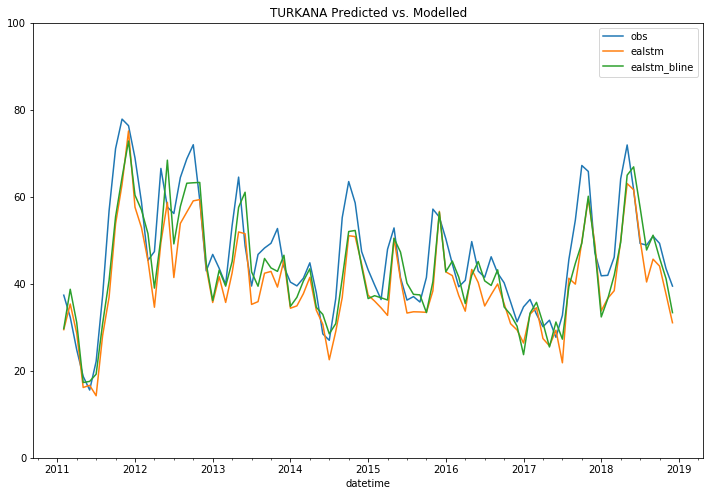

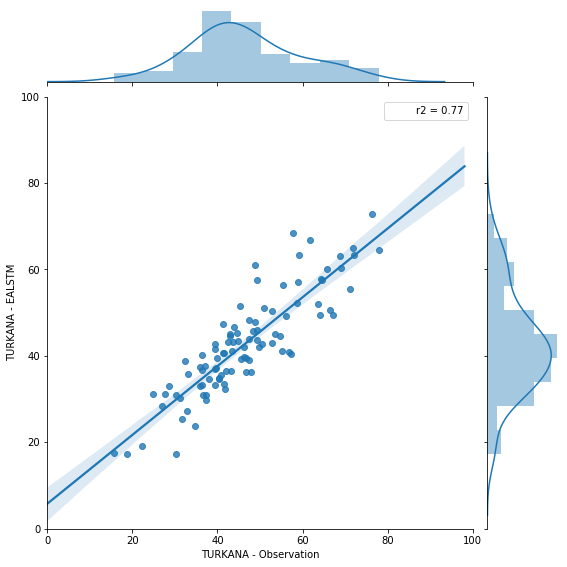

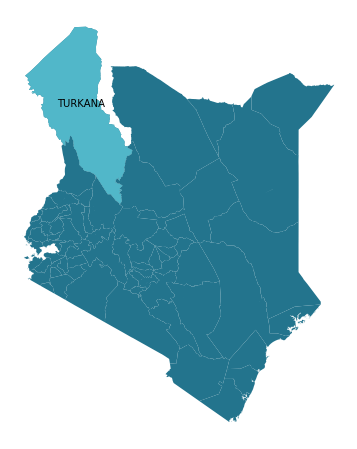

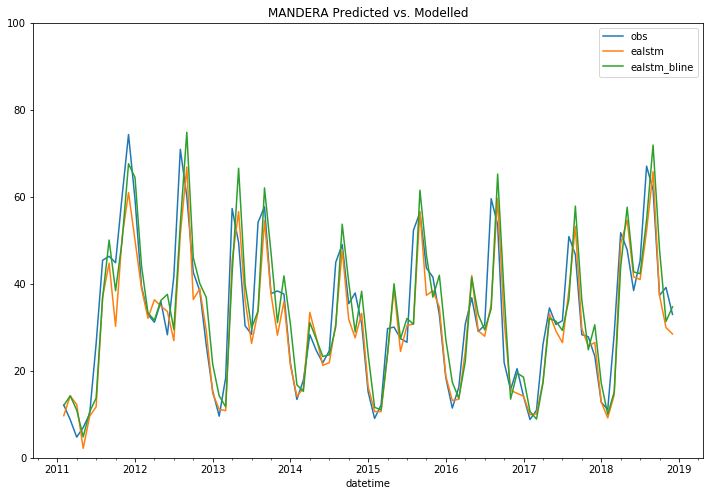

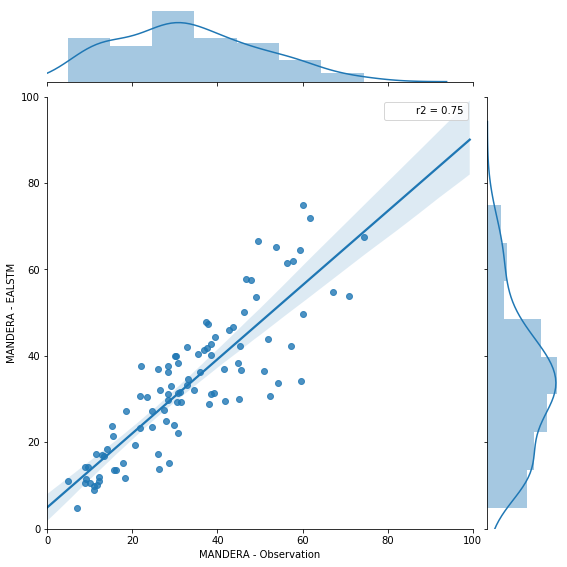

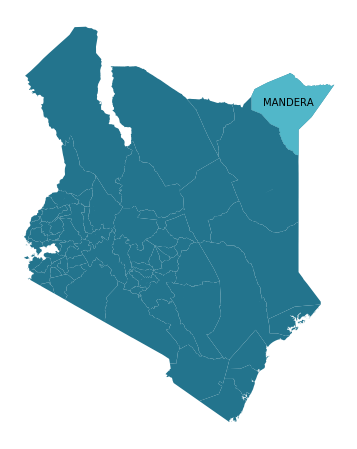

In [41]:
for region in regions[:2]:
    fig, ax = plt.subplots(figsize=(12,8))
    plot_region_time_series(region=region, ax=ax, model=['ealstm', 'ealstm_bline']);
    fig, ax = plot_region_performance(model='ealstm', region=region);
    highlight_selected_regions([region])

# Event Hits/Misses

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          **imshow_kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, **imshow_kwargs)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Quintiles of Vegetation Condition Index

In [43]:
def calculate_quintiles(da: xr.DataArray, new_variable_name: str = 'quintiles'):
    bins = [0.0, 20.0, 40.0, 60.0, 80.0]
    result = xr.apply_ufunc(np.digitize, da, bins)
    result = result.rename(new_variable_name)
    return result

mask = get_ds_mask(ds.VCI)
true_qs = calculate_quintiles(y_test.VCI).where(~mask)
pred_qs = calculate_quintiles(ealstm_pred.where(ealstm_pred > 0, 0).load()).where(~mask)
bline_qs = calculate_quintiles(bline_pred.load()).where(~mask)

In [44]:
test_da = y_test.VCI
test_da = ealstm_pred

# has it selected the right values? YES
print(test_da.where(vdi_true == 1).mean())
print(test_da.where(vdi_true == 2).mean())
print(test_da.where(vdi_true == 3).mean())
print(test_da.where(vdi_true == 4).mean())

NameError: name 'vdi_true' is not defined

In [ ]:
fig, ax = plt.subplots()
(pred_qs == true_qs).mean(dim='time').where(~mask).plot(ax=ax)
ax.set_title('How often do we predict the correct Quintiles?')


In [ ]:
times = true_qs.time.values
true_np = true_qs.stack(pixel=['lat', 'lon']).values.flatten()
preds_np = pred_qs.stack(pixel=['lat', 'lon']).values.flatten()
bline_np = bline_qs.stack(pixel=['lat', 'lon']).values.flatten()

In [ ]:
# np.set_printoptions(precision=2)

# plot_confusion_matrix(true_np, preds_np, classes=None, normalize=True,
#                       title='EALSTM Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})
# plot_confusion_matrix(true_np, bline_np, classes=None, normalize=True,
#                       title='BASELINE Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})

### test vegetation deficit index

In [ ]:
from src.analysis import VegetationDeficitIndex

v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true = v.vegetation_index_classify(y_test.VCI, 'vdi')
vdi_e1_pred = v.vegetation_index_classify(ealstm_pred.load(), 'vdi')
vdi_e2_pred = v.vegetation_index_classify(ealstm_best_pred.load(), 'vdi')
vdi_bline = v.vegetation_index_classify(bline_pred.load(), 'vdi')

print(vdi_true.min(), vdi_true.max())

In [ ]:
ealstm_base_rmse.load().shape

In [ ]:
# ds.VCI.where(ds.VCI < 80).isnull().mean()
# y_test.VCI.where(y_test.VCI < 80).isnull().mean()
y_test.VCI.where(true_qs == 5).min() #.max() .median()
y_test.VCI.where(true_qs == 5).min()

In [ ]:
fig, ax = plt.subplots()
(vdi_e1_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=ax, cmap='RdBu_r')
ax.set_title('How often do we predict the correct Vegetation Deficit Index?');

fig, ax = plt.subplots()
(vdi_e2_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=ax, cmap='RdBu_r')
ax.set_title('How often do we predict the correct Vegetation Deficit Index?');

## Plot the Vegetation Deficit Index (VDI) from Klisch & Atzberger 2016

Normalized confusion matrix
[[0.13 0.18 0.24 0.15 0.3 ]
 [0.09 0.16 0.25 0.16 0.33]
 [0.05 0.11 0.25 0.21 0.38]
 [0.04 0.08 0.23 0.24 0.42]
 [0.04 0.08 0.21 0.23 0.44]]
Normalized confusion matrix
[[0.14 0.18 0.24 0.15 0.29]
 [0.1  0.18 0.25 0.16 0.32]
 [0.07 0.13 0.26 0.19 0.35]
 [0.05 0.1  0.24 0.22 0.39]
 [0.05 0.1  0.22 0.23 0.41]]


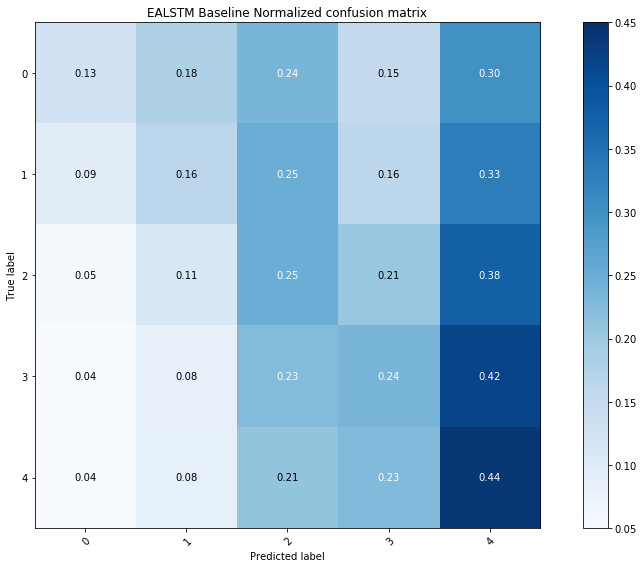

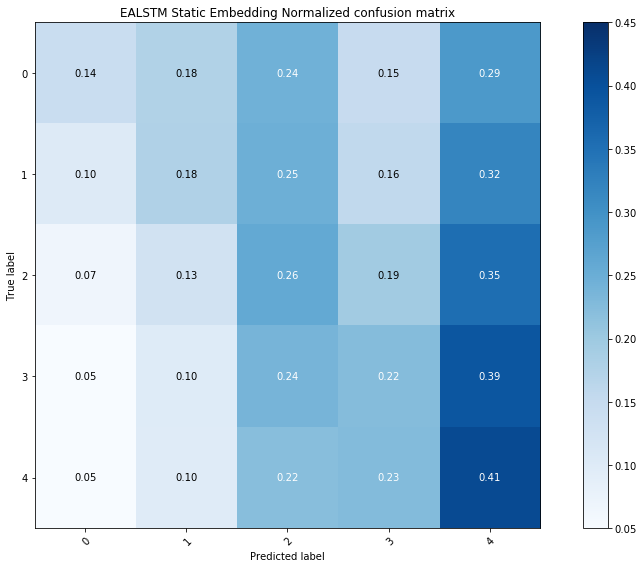

In [150]:
true_np = vdi_true.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_e1_np = vdi_e1_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_e2_np = vdi_e2_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np = vdi_bline.stack(pixel=['lat', 'lon']).values.flatten()


plot_confusion_matrix(true_np, preds_e1_np.clip(min=1, max=5), classes=None, normalize=True,
                      title='EALSTM Baseline Normalized confusion matrix',
                      **{'vmin': 0.05, 'vmax': 0.45})

plot_confusion_matrix(true_np, preds_e2_np.clip(min=1, max=5), classes=None, normalize=True,
                      title='EALSTM Static Embedding Normalized confusion matrix',
                      **{'vmin': 0.05, 'vmax': 0.45})

Normalized confusion matrix
[[0.15 0.17 0.21 0.15 0.32]
 [0.11 0.16 0.22 0.15 0.36]
 [0.08 0.12 0.22 0.18 0.41]
 [0.06 0.1  0.2  0.2  0.45]
 [0.06 0.09 0.19 0.2  0.46]]


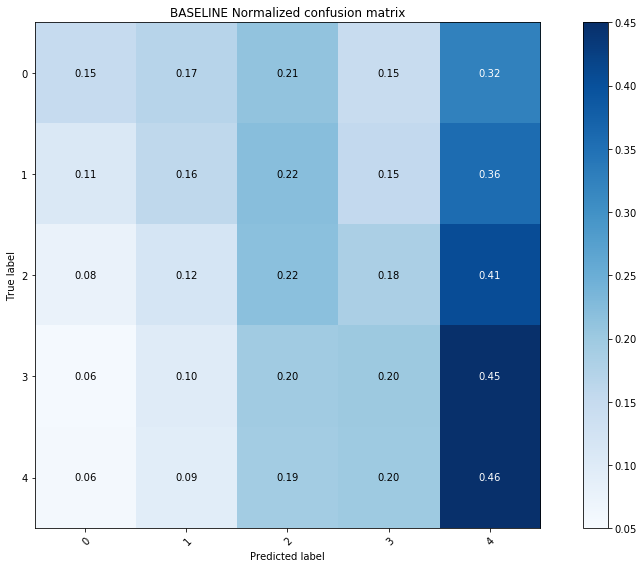

In [151]:
plot_confusion_matrix(true_np, bline_np, classes=None, normalize=True,
                      title='BASELINE Normalized confusion matrix',
                      **{'vmin': 0.05, 'vmax': 0.45})

# What about if we fix the timeshift error?